# Anime Recommendation System
#### Alejandra Avitia-Davila, Crystal Feng, Simon Chau, and Tyler Lafond
### Project Objective:
**The purpose of this anime recommendation system is to provide a way for people to find anime that they would be interested in based on their tastes in anime. Since it can be difficult to find new shows to watch, having a system that recommends anime for others would solve the problem of finding something new to watch.**

### Cleaning Data:
Our data was taken from: https://www.kaggle.com/marlesson/myanimelist-dataset-animes-profiles-reviews/version/1?select=profiles.csv. The data sets that we used for our recommendation system are anime.csv and profiles.csv. 
	
“anime.csv” contains a list of different animes. It contains information on the anime’s title, synopsis, genre, air date, number of episodes, the number of members on myanimelist who had this anime in their list, its popularity, ranking, and score. To clean the data, we only kept the columns that are listed below. We then saved our cleaned data onto a new dataset called “clean_animes.csv”. 
- uid: The special ID given to the anime
- title: The title of the anime
- genre: A list of genres for the given anime
- popularity: The popularity rank of the anime on myanimelist
- ranked: The score rank of the anime on myanimelist
- score: The score for the given anime on myanimelist

“profiles.csv” contains information about users on myanimelist.com who watch anime. This data set contains information on the user’s username, gender, birthday, a list of their favorite anime, and a link to their myanimelist profile. To clean this data set we kept the columns that are listed below. We then save our cleaned data onto a new dataset called “clean_profile.csv”.
- profile: which is the user’s profile name. 
- favorites_animes: which holds a list of the user’s favorite anime’s uid.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#cleaning data
animes_df = pd.read_csv("animes.csv")
animes_df = animes_df.drop(columns=['synopsis', 'aired', 'episodes', 'members', 'img_url', 'link']).drop_duplicates()
profiles_df = pd.read_csv("profiles.csv")
profiles_df = profiles_df.drop(columns = ['gender', 'birthday', 'link']).drop_duplicates()


print(animes_df.head())
print(profiles_df.head())
print(len(profiles_df.index))
#profiles_df_2 = profiles_df.head(5)

#saving cleaned data into new csv files
animes_df.to_csv("clean_animes.csv", index=False)
profiles_df.to_csv("clean_profiles.csv", index=False)

     uid                             title  \
0  28891           Haikyuu!! Second Season   
1  23273           Shigatsu wa Kimi no Uso   
2  34599                     Made in Abyss   
3   5114  Fullmetal Alchemist: Brotherhood   
4  31758  Kizumonogatari III: Reiketsu-hen   

                                               genre  popularity  ranked  \
0  ['Comedy', 'Sports', 'Drama', 'School', 'Shoun...         141    25.0   
1  ['Drama', 'Music', 'Romance', 'School', 'Shoun...          28    24.0   
2  ['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...          98    23.0   
3  ['Action', 'Military', 'Adventure', 'Comedy', ...           4     1.0   
4   ['Action', 'Mystery', 'Supernatural', 'Vampire']         502    22.0   

   score  
0   8.82  
1   8.83  
2   8.83  
3   9.23  
4   8.83  
           profile                                    favorites_anime
0   DesolatePsyche  ['33352', '25013', '5530', '33674', '1482', '2...
1        baekbeans  ['11061', '31964', '853', '20583', '918'

#### Defining functions:
These are some helper functions for our recommendation system to help identify genres of a given anime, the list of favorites from a given profile, and the name of an anime from a given unique id.
- genre_list(anime_uid)
- anime_list(profile)
- anime_name(anime_uid)

In [2]:
def genre_list(anime_uid):
    if(anime_uid == ""): return []
    anime_uid = int(anime_uid)
    if(len(animes_df.loc[animes_df["uid"] == anime_uid]) == 0): return []
    raw_genres = animes_df.loc[animes_df["uid"] == anime_uid]["genre"].array[0]
    genres = raw_genres.strip("][").replace("'", "").split(", ")
    for genre in genres:
        genre = genre.replace(" ", "")
    return genres

#print(genre_list(33352))

def anime_list(profile):
    if(profile > len(profiles_df.index)) : return []
    raw_favorites = profiles_df.iloc[profile]["favorites_anime"]
    favorites = raw_favorites.strip("][").replace("'", "").split(", ")
    for anime in favorites:
        anime = anime.replace("'", "")
    return favorites
    
#print(anime_list(0))

def anime_name(anime_uid):
    if(anime_uid == ""): return ""
    anime_uid = int(anime_uid)
    if(len(animes_df.loc[animes_df["uid"] == anime_uid]) == 0): return ""
    return animes_df.loc[animes_df["uid"] == anime_uid]["title"].array[0]

#print(anime_name(28891))

def gen_frequencies(anime_list):
    curr_list = []
    for anime_uid in anime_list:
        uid = anime_uid.replace("'", "")
        curr_list += genre_list(uid)
    num_genres = len(curr_list)
    genre_series = pd.Series(curr_list)
    genre_frequencies = genre_series.value_counts() / num_genres
    return genre_frequencies

def age(birthday):
    if(len(birthday) > 8):
        year_of_birth = int(birthday[-4:])
        return 2021-year_of_birth

### Computing frequencies for profiles
Here we computed the frequencies of how often a genre appeared out of a users list of favorite animes, and stored them into a new csv file for efficiency since this process takes quite a bit of time, given the size of the profiles dataset. These genre-frequencies indicate the genres a specific user tends to enjoy watching, and are the basis for our recommendation system.

In [13]:
#commented out and saved to csv since this process takes a while

#df_profile_freq = pd.DataFrame() #index is same as profile_df_index
#for profile in profiles_df.index:
#    favorites = anime_list(profile)
#    genres = []
#    for anime in favorites:
#        genres += genre_list(anime)
#    genre_series = pd.Series(genres)
#    num_genres = len(genres)
#    genre_frequencies = genre_series.value_counts() / num_genres
#    df_profile_freq = df_profile_freq.append(genre_frequencies, ignore_index=True)
#df_profile_freq = df_profile_freq.drop(columns=[""])
#df_profile_freq = df_profile_freq.fillna(0)
#df_profile_freq.to_csv("profile_genres.csv", index=False)

### EDA
In the following section, we explored the popularity of genres in general, as well as with respect to a specific gender of anime watchers. Additionally, we explored the distribution of ages within our profiles data in order to see the average age, as well as the oldest age.

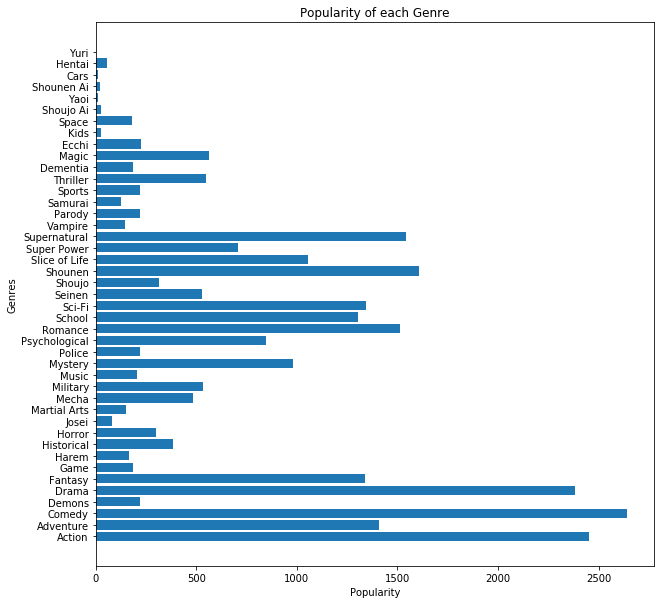

The 5 most popular anime genres are: Comedy, Action, Drama, Shounen, and Supernatural


In [4]:
df_freq = pd.read_csv("profile_genres.csv")
genres = df_freq.columns
sums=[]
for genre in genres:
    curr = df_freq[genre].sum()
    sums.append(curr)

plt.figure(figsize=(10,10))
plt.barh(genres, sums)
plt.ylabel("Genres")
plt.xlabel("Popularity")
plt.title("Popularity of each Genre")
plt.show()

print("The 5 most popular anime genres are: Comedy, Action, Drama, Shounen, and Supernatural")

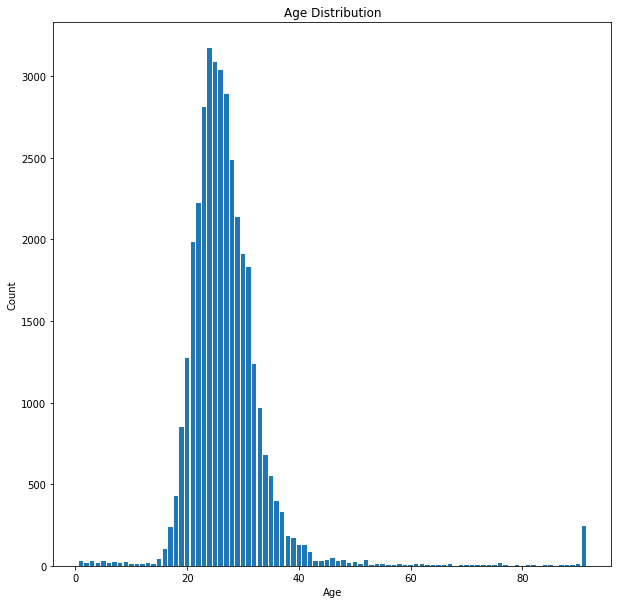

The max age of profiles is 91 years old
The average age of users is around 27 years old


In [27]:
raw_profile_df = pd.read_csv("profiles.csv")
raw_profile_df = raw_profile_df["birthday"].dropna()
birthdays = []
for row in raw_profile_df.index:
    if(type(age(raw_profile_df[row])) is not 'NoneType'):
        birthdays.append(age(raw_profile_df[row]))
birthdays = [i for i in birthdays if i]

birthday_series = pd.Series(birthdays)
birthday_series = birthday_series.value_counts()

plt.figure(figsize=(10,10))
plt.bar(birthday_series.index, birthday_series)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

oldest = max(birthdays)
avg = sum(birthdays) / len(birthdays)

print("The max age of profiles is", oldest, "years old")
print("The average age of users is around", int(avg), "years old")

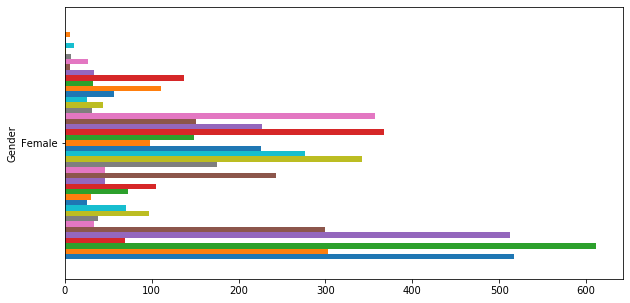

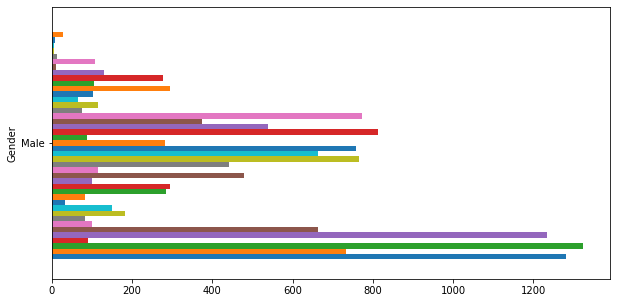

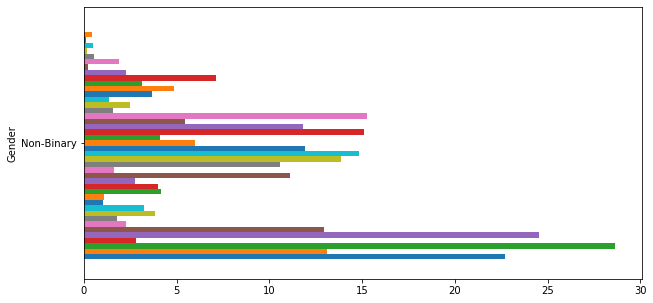

In [28]:
df_g = pd.read_csv("profile_genres.csv")
df_g["Gender"] = pd.read_csv("profiles.csv")["gender"]
df_f = df_g.loc[df_g['Gender'] == "Female"]
testf = df_f.groupby("Gender")[genres].sum() ## sum the squares
testf.plot.barh(figsize=(10, 5),width=3,legend=False)

df_m = df_g.loc[df_g['Gender'] == "Male"]
testf = df_m.groupby("Gender")[genres].sum() ## sum the squares
testf.plot.barh(figsize=(10, 5),width=3,legend=False)

df_n = df_g.loc[df_g['Gender'] == "Non-Binary"]
testf = df_n.groupby("Gender")[genres].sum() ## sum the squares
testf.plot.barh(figsize=(10, 5),width=3,legend=False)

### PCA Decomposition on profile genre frequencies
When looking at our data, we wanted to reduce the dimensional space of our data’s features to have better visualization. To accomplish this we performed a principal component analysis with 5 principal components on our frequency data frame. To make sure we were not losing too much variance from our original data we checked the combined explained variance ratio from each component of the PCA which was 61.9%, which means we still have 61.9% of our original data. We based the rest of the project on these new dimensions. 

In [6]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(df_freq)
print("Explained variation per principal component:", pca.explained_variance_ratio_)
cumulative_variance = sum(pca.explained_variance_ratio_) 
print('Cumulative variance explained by 5 principal components: ', cumulative_variance)

Explained variation per principal component: [0.30673005 0.11921416 0.08733801 0.05529435 0.05119774]
Cumulative variance explained by 5 principal components:  0.6197743146812288


### Using Elbow Method with WCSS to determine optimal k-value and Implementing our K-Means Clustering model

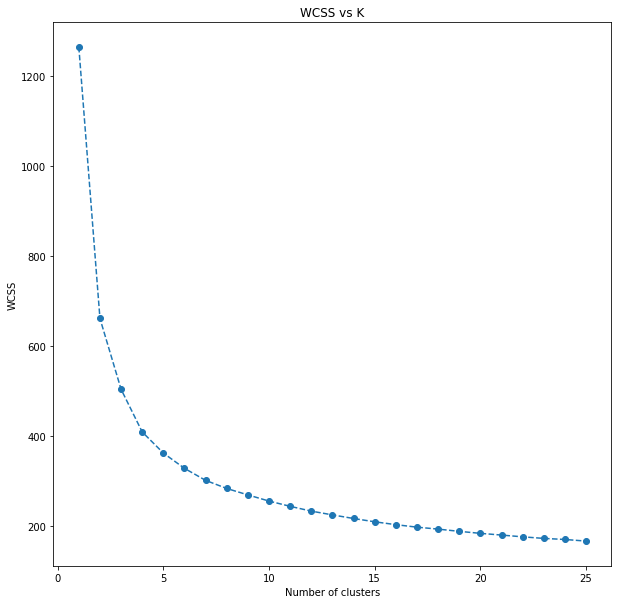

In [7]:
wcss = []
for i in range(1, 26):
    k_means = KMeans(n_clusters=i, init='k-means++', random_state=20)
    k_means.fit(pca_result)
    wcss.append(k_means.inertia_)

    
plt.figure(figsize=(10,10))
plt.plot(range(1,26), wcss, marker="o", linestyle='--')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("WCSS vs K")
plt.show()

In [8]:
optimal_k = 5
final_k_means = KMeans(n_clusters = optimal_k, init = "k-means++", random_state=20)
final_k_means.fit(pca_result)
df_pca_kmeans = pd.concat([profiles_df.reset_index(drop=True), pd.DataFrame(pca_result)], axis=1)
df_pca_kmeans.columns.values[-5:] = ["Component 1", "Component 2", "Component 3", "Component 4", "Component 5"]
df_pca_kmeans["Cluster"] = final_k_means.labels_
mapping = {0:'first', 1:"second", 2:"third", 3:"fourth", 4:"fifth"}
df_pca_kmeans["Cluster"] = df_pca_kmeans["Cluster"].map(mapping)

df_freq["Cluster"] = final_k_means.labels_
df_freq["Cluster"] = df_freq["Cluster"].map(mapping)

In [9]:
#print(df_pca_kmeans.head())
print(df_freq.head())
third_cluster = df_freq.loc[df_freq["Cluster"] == 'third']

     Action  Adventure    Comedy    Demons     Drama   Fantasy      Game  \
0  0.078431   0.078431  0.088235  0.009804  0.088235  0.049020  0.009804   
1  0.106383   0.042553  0.127660  0.000000  0.042553  0.063830  0.000000   
2  0.063830   0.021277  0.063830  0.000000  0.106383  0.063830  0.000000   
3  0.125000   0.041667  0.125000  0.000000  0.041667  0.083333  0.000000   
4  0.000000   0.020833  0.166667  0.000000  0.083333  0.000000  0.041667   

      Harem  Historical    Horror  ...  Ecchi  Kids  Space  Shoujo Ai  Yaoi  \
0  0.009804    0.019608  0.019608  ...    0.0   0.0    0.0        0.0   0.0   
1  0.021277    0.021277  0.000000  ...    0.0   0.0    0.0        0.0   0.0   
2  0.000000    0.021277  0.021277  ...    0.0   0.0    0.0        0.0   0.0   
3  0.000000    0.000000  0.000000  ...    0.0   0.0    0.0        0.0   0.0   
4  0.000000    0.000000  0.000000  ...    0.0   0.0    0.0        0.0   0.0   

   Shounen Ai  Cars  Hentai  Yuri  Cluster  
0         0.0   0.0    

### Using KNN to classify new users into a cluster

              precision    recall  f1-score   support

       fifth       0.97      0.96      0.97      2683
       first       0.96      0.98      0.97      3624
      fourth       0.97      0.95      0.96      2128
      second       1.00      1.00      1.00      8223
       third       0.96      0.95      0.95      2503

    accuracy                           0.98     19161
   macro avg       0.97      0.97      0.97     19161
weighted avg       0.98      0.98      0.98     19161

[[2581   46   10    0   46]
 [  13 3569   22    0   20]
 [  28   54 2015    0   31]
 [   2    3    0 8212    6]
 [  29   63   31    0 2380]]


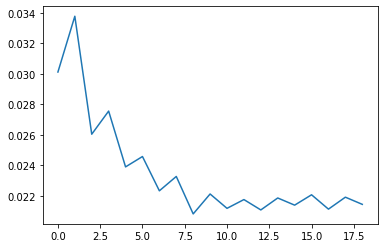

In [10]:
scaler = StandardScaler()
scaler.fit(df_pca_kmeans.drop(columns=['Cluster', 'profile', 'favorites_anime'], axis = 1))
scaled_features = scaler.transform(df_pca_kmeans.drop(columns=['Cluster', 'profile', 'favorites_anime'], axis = 1))
scaled_data = pd.DataFrame(scaled_features, columns = df_pca_kmeans.drop(columns=['Cluster', 'profile', 'favorites_anime'], axis = 1).columns)
scaled_data.head()
from sklearn.model_selection import train_test_split
x = scaled_data
y = df_pca_kmeans['Cluster']
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.4)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
model = KNeighborsClassifier(n_neighbors = 13)
model.fit(x_training_data, y_training_data)
predictions = model.predict(x_test_data)
error_rates = []
for i in np.arange(1, 20):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))
%matplotlib inline
plt.plot(error_rates)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test_data, predictions))
print(confusion_matrix(y_test_data, predictions))

## Finding Recommendations 

In [11]:
#input users' favorite animes
user1 = ['37510', '38000', '30276', '552', '32998'] #action, shounen
user2 = ['1735', '813', '11757', '31964', '32281'] #action, fantasy, shounen, romance
user3 = ['5114', '1535', '2167', '22319', '120'] #fantasy, romance, military, mystery, horror, comedy

#maintaining size of input with model input
new_df_3 = df_freq.append(gen_frequencies(user1), ignore_index=True)
new_df_3 = new_df_3.append(gen_frequencies(user2), ignore_index=True)
new_df_3 = new_df_3.append(gen_frequencies(user3), ignore_index=True)
#cleaning new input data to work with model
new_df_3 = new_df_3.fillna(0)
new_df_3 = new_df_3.drop(columns=['Cluster'], axis=1)
new_df_3 = new_df_3.drop(new_df_3.index[:-3])
#print(new_df_3)
new_users_result = pca.transform(new_df_3)
#using knn model to classify new users into predefined clusters
out = list(model.predict(new_users_result))
#print(out)

#original profiles of respective clusters of input users
cluster_1 = df_freq.loc[df_freq["Cluster"] == out[0]]
cluster_2 = df_freq.loc[df_freq["Cluster"] == out[1]]
cluster_3 = df_freq.loc[df_freq["Cluster"] == out[2]]

#user 1:
dist1 = cluster_1.drop("Cluster", axis=1).sub(new_df_3.iloc[0], axis=1).pow(2).sum(axis=1).pow(.5)
#user 2:
dist2 = cluster_2.drop("Cluster", axis=1).sub(new_df_3.iloc[1], axis=1).pow(2).sum(axis=1).pow(.5)
#user 3:
dist3 = cluster_3.drop("Cluster", axis=1).sub(new_df_3.iloc[2], axis=1).pow(2).sum(axis=1).pow(.5)

#5 closest neighbors of users:
neighbors_1 = dist1.nsmallest(5).index
neighbors_2 = dist2.nsmallest(5).index
neighbors_3 = dist3.nsmallest(5).index

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [12]:
#user 1 recommendations:
recommendation_1 = []
for user in neighbors_1:
    current_favorites = profiles_df.iloc[user]["favorites_anime"].strip("][").replace("'", "").split(", ")
    for i in current_favorites:
        if (i not in recommendation_1) and (i not in user1):
            recommendation_1.append(i)
    
for i in range(0, len(recommendation_1)):
    recommendation_1[i] = anime_name(recommendation_1[i])
    

recommendation_2 = []
for user in neighbors_2:
    current_favorites = profiles_df.iloc[user]["favorites_anime"].strip("][").replace("'", "").split(", ")
    for i in current_favorites:
        if (i not in recommendation_2) and (i not in user2):
            recommendation_2.append(i)
    
for i in range(0, len(recommendation_2)):
    recommendation_2[i] = anime_name(recommendation_2[i])
    
recommendation_3 = []
for user in neighbors_3:
    current_favorites = profiles_df.iloc[user]["favorites_anime"].strip("][").replace("'", "").split(", ")
    for i in current_favorites:
        if (i not in recommendation_3) and (i not in user3):
            recommendation_3.append(i)
    
for i in range(0, len(recommendation_3)):
    recommendation_3[i] = anime_name(recommendation_3[i])
    
print("User 1's recommendations:", recommendation_1, "\n")
print("User 2's recommendations:", recommendation_2, "\n")
print("User 3's recommendations:", recommendation_3, "\n")

User 1's recommendations: ['Mononoke Hime', 'Fate/Zero 2nd Season', 'Mob Psycho 100', 'Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare', 'Gintama°', 'One Piece', 'Baccano!', 'Tengen Toppa Gurren Lagann', 'Fate/Zero', 'Toradora!', 'Yuu☆Yuu☆Hakusho', 'Hunter x Hunter (2011)', 'Code Geass: Hangyaku no Lelouch', 'Cowboy Bebop', 'Black Lagoon', 'Gintama', 'Durarara!!', 'Kaze Tachinu', 'Noragami', 'Black Lagoon: The Second Barrage', 'Samurai Champloo', 'Baccano! Specials', 'Gankutsuou'] 

User 2's recommendations: ['Hunter x Hunter (2011)', 'Shingeki no Kyojin', 'Naruto', 'Akatsuki no Yona', 'Haikyuu!!', 'Ore Monogatari!!', 'Ansatsu Kyoushitsu 2nd Season', 'One Punch Man', 'One Piece', 'Shokugeki no Souma', 'No Game No Life', 'Boruto: Naruto Next Generations', 'Fairy Tail', 'Toradora!', 'Accel World', 'Bleach', 'Fairy Tail Movie 2: Dragon Cry', 'Koukyoushihen Eureka Seven', 'Soul Eater', 'Medaka Box'] 

User 3's recommendations: ['Banana Fish', 'Zetsuen no Tempest', 'Seishun Buta Yarou